In [2]:
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
# plotting
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

In [3]:
#sqqq and tqqq are taken as IBdata feed not for SPXS 
path = '/home/octo/Dropbox/IQ_data/'
spy=pd.read_csv(path + 'SPY.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
sqqq= pd.read_csv(path + 'SQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
tqqq=pd.read_csv(path + 'TQQQ.csv',names = ["high", "low", "open","close","total_volume","volume"],index_col=0, parse_dates=True)
spy=spy.tail(140000)
sqqq=sqqq.tail(140000)
tqqq=tqqq.tail(140000)

In [4]:
#df for datascience
df=pd.DataFrame(data=spy)
#df_ml for machine learning
df_ml=pd.DataFrame(data=spy.open)

In [5]:
#df['time']=df.index.strftime('%H:%M:%S')
time=df.index.strftime('%H:%M:%S')

### EO will capture the overnight news impact

In [6]:
# difference at '09:30:05' from last day close
EO=np.where(time=='09:30:05',df.open-df.close.shift(1),0)
#last spread value at all cells
df['EO']=EO[time=='09:30:05'][-1]

In [7]:
df['H']=pd.rolling_max(df.high,4600)
df['L']=pd.rolling_min(df.low,4600)
df['M']=(df.H+df.L)/2

In [8]:
P=(spy.high+spy.low+spy.close)/3
df['vwap'] =pd.rolling_sum(spy.volume*P,12)/pd.rolling_sum(spy.volume,12)
df['spread']=pd.rolling_sum(pd.DataFrame(data=(spy.open-df.vwap)),60)
df['spreadqtop']=pd.rolling_quantile(df.spread,1000,.9)
df['spreadqbot']=pd.rolling_quantile(df.spread,1000,.0)
df['spreadb']=np.where(df.spread>df.spreadqtop,1,np.where(df.spread<df.spreadqbot,-1,0))

In [9]:
df['speed']=pd.rolling_sum(pd.DataFrame(data=(spy.open-spy.close.shift(1))),60)
df['speedQtop']=pd.rolling_quantile(df.speed,1000,.7)
#df['speedQbot']=pd.rolling_quantile(df.speed,1000,.1)
#df['speedb']=np.where(df.speed>df.speedQtop,1,np.where(df.speed<df.speedQbot,-1,0))
df['speedb']=np.where(df.speed<df.speedQtop,1,0)

#### Regression for feature generation: Spread

In [ ]:
### pending  /ALGO/SPY_UD_ML_17022017.ipynb

# SPREAD

In [10]:
OO=np.where(time=='09:30:05',df.open,0)
HO=np.where(time=='09:30:05',df.H,0)
LO=np.where(time=='09:30:05',df.L,0)
MO=np.where(time=='09:30:05',df.M,0)

In [11]:
O=OO[time=='09:30:05'][-1]
H=HO[time=='09:30:05'][-1]
L=LO[time=='09:30:05'][-1]
M=MO[time=='09:30:05'][-1]
# for finding market state. EO for sentiment 
OH=O-H # +ve shows jump up
OL=L-O # +ve shows jump down
MO=M-O # +ve for state 2 or buy | -ve for state 3 or SS
df['OL']=O
df['HL']=H
df['LL']=L
df['ML']=M

#### Market spread from opening price

In [12]:
#df['EO']=np.where(EO==0,EO[time=='09:30:05'][-1],0)
df['OO']=df.open-O # changing points

#### H L M price spread from opening price

In [13]:
#df['HO']=df.open-H # positive spread if at state 4
#df['LO']=L- df.open # +ve shows jump down
df['MO']=df.open-M # +ve for state 2 or buy | -ve for state 3 or SS

##### VWAP spread

In [14]:
df_ml['spread']=df['spreadb'] # higher spread leads to reversal

### Velocity

In [15]:
df_ml['speed']=df['speedb'] # 1 shows acceptable speed

## Sentiment

In [41]:
df['S']=np.where(df.EO>0,1,np.where(df.EO<-0,-1,0))

## Market state

In [17]:
df['MS']=np.where(OH>0,4,np.where(MO<0,3,np.where(MO>0,2,np.where(OL>0,1,0))))

In [18]:
df_ml['S']=df['S']
df_ml['MS']=df['MS']
df_ml['EO']=df['EO']
df_ml['OO']=df['OO']
#df_ml['HO']=df['HO']
#df_ml['LO']=df['LO']
df_ml['MO']=df['MO']

## Reversal

In [50]:
# reversal, when market up or down
df['NL']=pd.rolling_sum(pd.DataFrame(data=spy.open-spy.close.shift(60)),12)
#df['spread']=df.open -df['vwap']
df['NLqtop']=pd.rolling_quantile(df.NL,720,.9)
df['NLqbot']=pd.rolling_quantile(df.NL,720,.1)
df['R']=np.where(df.NL>df.NLqtop,1,np.where(df.j<df.NLqbot,1,0)) # only considering 1 and 0

#### volume should be above 30%

In [21]:
# only when volume ==1
volQbot=pd.rolling_quantile(spy.volume,1000,.3)
df['vol']=np.where(spy.volume<volQbot,0,1)
df_ml['V']=df['vol']

## Visual

In [22]:
df_ml.tail()

,open,spread,speed,S,MS,EO,OO,MO,R,RC,V
2017-03-01 15:59:40,239.72,0,1,1,3,1.87,1.34,2.4775,0,-1,1
2017-03-01 15:59:45,239.78,0,1,1,3,1.87,1.40,2.5375,0,-1,1
2017-03-01 15:59:50,239.78,0,1,1,3,1.87,1.40,2.5375,0,-1,1
2017-03-01 15:59:55,239.75,0,1,1,3,1.87,1.37,2.5075,0,-1,1
2017-03-01 16:00:00,239.72,0,1,1,3,1.87,1.34,2.4775,0,-1,1


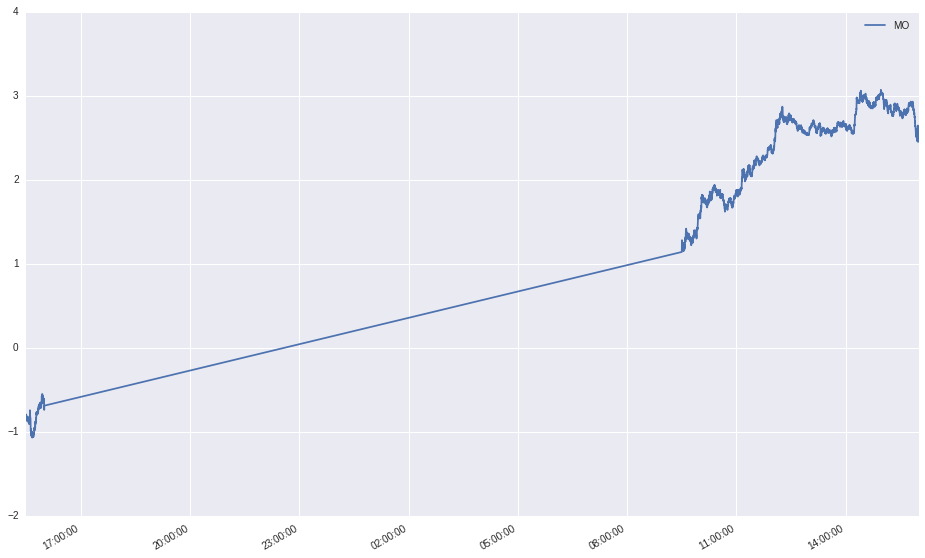

In [56]:
df[['MO']].tail(5000).plot(figsize=(16, 10))
plt.show()

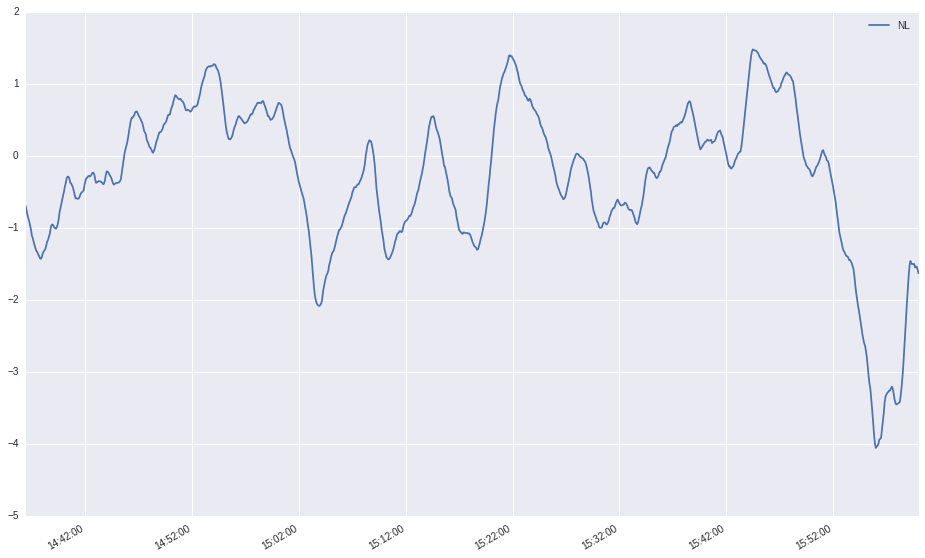

In [53]:
df[['NL']].tail(1000).plot(figsize=(16, 10))
plt.show()

In [ ]:
#df_ml[['EO','HO','LO','MO','OO']].tail(1000).plot(figsize=(16, 10))
#df_ml[['EO','HO','LO']].tail(1000).plot(figsize=(16, 10))
df_ml[['EO','MO']].tail(1000).plot(figsize=(16, 10))
plt.show()

In [ ]:
#df_ml[['spread','S','MS','R','RC','V']].tail(5000).plot(figsize=(16, 10))
df[['MS']].plot(figsize=(16, 10))
plt.show()

### ANother data set with values not 0-1

In [42]:
df_val=pd.DataFrame(data=spy.open)
df_val['spread']=df['spread'] # spread from VWAP
df_val['speed']=df['speed'] # higher speed is bad
df_val['MO']=df['MO'] # market position  from mean value
df_val['MS']=df['MS'] # market state 4 states
df_val['S']=df['S']# difference at '09:30:05' from last day close
df_val['R']=df['R']

In [43]:
# reduce dataset based on volume and speed
df_val=df_val[df.vol!=0] # all decision when volume above 30% or vol==1
df_val=df_val[df.speedb!=0] # 1 shows acceptable speed
df_val=df_val.dropna()

In [44]:
df_val.tail()

,open,spread,speed,MO,MS,S,R1,R2
2017-03-01 15:59:40,239.72,-0.477297,-0.0282,2.4775,3,1,1,0
2017-03-01 15:59:45,239.78,-0.429714,-0.0182,2.5375,3,1,1,0
2017-03-01 15:59:50,239.78,-0.378651,-0.0232,2.5375,3,1,1,0
2017-03-01 15:59:55,239.75,-0.359606,-0.0232,2.5075,3,1,1,0
2017-03-01 16:00:00,239.72,-0.369014,-0.0232,2.4775,3,1,1,0


# Buy Sell signal